# Entropy scaling of pure substances

## Goal

- Learn how to compute dynamic properties (viscosity in this example)
- Compare substance specific parameters against homo-segmented group contribution
- Compare viscosity to NIST data (generated in NIST's [webapp](https://webbook.nist.gov/chemistry/fluid/))

## Import needed packages

In [1]:
from feos.pcsaft import *
from feos.eos import *
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import si_units as si

sns.set_context("talk")
sns.set_palette("Dark2")
sns.set_style("ticks")

## PC-SAFT (individual component parameters)

First, we read parameters adjusted to hexane saturation pressure and liquid densities (for the regular SAFT parameters) and to viscosity (for correlation). 

In [2]:
parameters = PcSaftParameters.from_json(
    ["hexane"], "../parameters/pcsaft/loetgeringlin2018.json"
)
parameters

|component|molarweight|$m$|$\sigma$|$\varepsilon$|$\mu$|$Q$|$\kappa_{AB}$|$\varepsilon_{AB}$|$N_A$|$N_B$|$N_C$|
|-|-|-|-|-|-|-|-|-|-|-|-|
|hexane|86.177|3.0576|3.7983|236.77|-|-|-|-|0|0|0|

## PC-SAFT homo-GC

For transparency, we build parameters by hand. You can read a detailed explanation about PC-SAFT parameters in the "working with parameters" tutorial.

In [3]:
hexane = ChemicalRecord(
    identifier=Identifier(
        cas="110-54-3",
        name="hexane",
        iupac_name="hexane",
        smiles="CCCCCC",
        inchi="InChI=1/C6H14/c1-3-5-6-4-2/h3-6H2,1-2H3",
        formula="C6H14"
    ),
    segments=['CH3', 'CH2', 'CH2', 'CH2', 'CH2', 'CH3']
)

ch3 = SegmentRecord(
    'CH3', 
    molarweight=15.0345, 
    model_record=PcSaftRecord(
        m=0.61198, sigma=3.7202, epsilon_k=229.90,
        viscosity=[-8.6878e-3, -1.7951e-1, -12.2359e-2, -0.01245]
    )
)

ch2 = SegmentRecord(
    'CH2', 
    molarweight=14.02658, 
    model_record=PcSaftRecord(
        m=0.45606, sigma=3.8900, epsilon_k=239.01,
        viscosity=[-0.9194e-3, -1.3316e-1, -4.2657e-2, -0.01245]
    )
)

segment_records = {r.identifier: r for r in [ch3, ch2]}

def from_segments(chemical_record, segment_records):
    m = 0
    s3 = 0
    eps = 0
    mw = 0
    viscosity = np.zeros(4)
    for s in chemical_record.segments:
        segment = segment_records[s]
        mw += segment.molarweight
        m += segment.model_record.m
        s3 += segment.model_record.m * segment.model_record.sigma**3
        eps += segment.model_record.m * segment.model_record.epsilon_k
        v = segment.model_record.viscosity
        viscosity += np.array([
            v[0] * segment.model_record.m * segment.model_record.sigma**3, 
            v[1] * segment.model_record.m * segment.model_record.sigma**3, 
            v[2], 
            v[3]
        ])
    viscosity[1] /= s3**0.45
    
    # We have to shift the "A" parameter because the implemented reference
    # is eta_CE according to eq. 3 of Loetgerin-Lin (2018)
    # A = A(GC) + log(sqrt(1/m)) = -log(m)/2
    viscosity[0] += np.log(np.sqrt(1/m))
    saft_record = PcSaftRecord(m, np.cbrt(s3 / m), eps / m, viscosity=viscosity)
    return PureRecord(chemical_record.identifier, mw, saft_record)

### Build equations of state

We instantiate an equation of state for each parameter set. `saft` uses substance specific parameters while `saft_gc` uses homo GC parameters both for SAFT as well as correlation parameters.

In [4]:
parameters_gc = PcSaftParameters.new_pure(from_segments(hexane, segment_records))
saft_gc = EquationOfState.pcsaft(parameters_gc)
saft = EquationOfState.pcsaft(parameters)

m_gc = parameters_gc.pure_records[0].model_record.m
m = parameters.pure_records[0].model_record.m

### Compare parameters

In [5]:
print("Substance specific: ", parameters.pure_records[0].model_record.viscosity)
print("Segments          : ", parameters_gc.pure_records[0].model_record.viscosity)

Substance specific:  [-1.2035, -2.5958, -0.4816, -0.0865]
Segments          :  [-1.2034921145837285, -2.536713016411593, -0.415346, -0.0747]


## Compare methods to NIST data (T = 450 K)

We will compute the residual entropy, viscosity and logarithmic reduced viscosity and compare to literature data (for which the entropy is computed with parameters fitted to the component, not GC).

In [6]:
literature = pd.read_csv("data/hexane_nist.csv", delimiter="\t")
literature.head()

,Temperature (K),Pressure (MPa),Density (mol/m3),Volume (m3/mol),Internal Energy (kJ/mol),Enthalpy (kJ/mol),Entropy (J/mol*K),Cv (J/mol*K),Cp (J/mol*K),Sound Spd. (m/s),Joule-Thomson (K/MPa),Viscosity (Pa*s),Therm. Cond. (W/m*K),Phase
0,450.0,0.01,2.6774,0.373500,45.229,48.964,154.33,193.37,201.76,212.47,11.204,0.000009,0.029374,vapor
1,450.0,0.11,29.9840,0.033351,45.065,48.734,134.03,193.94,203.09,209.04,11.510,0.000009,0.029276,vapor
2,450.0,0.21,58.3290,0.017144,44.896,48.496,128.27,194.53,204.55,205.48,11.842,0.000009,0.029196,vapor
3,450.0,0.31,87.8260,0.011386,44.720,48.249,124.64,195.15,206.15,201.76,12.207,0.000009,0.029136,vapor
4,450.0,0.41,118.6100,0.008431,44.536,47.992,121.90,195.80,207.93,197.87,12.608,0.000010,0.029098,vapor


We loop through experimental data, read temperature, pressure and the phase (liquid or vapor) and generate `State` objects for the experimental conditions. Then, we compute the residual molar entropy and the logarithmic reduced viscosity.

In [7]:
results = []
for i, row in literature.iterrows():
    t = row['Temperature (K)'] * si.KELVIN
    p = row['Pressure (MPa)'] * si.MEGA * si.PASCAL
    viscosity_lit = row['Viscosity (Pa*s)'] * si.PASCAL * si.SECOND
    
    # literature
    state = State(saft, temperature=t, pressure=p, total_moles=si.MOL, density_initialization=row.Phase)
    s = state.molar_entropy(Contributions.Residual)
    results.append(
        {
            "pressure": p / si.MEGA / si.PASCAL,
            "s*_res/m": s / si.RGAS / m,
            "viscosity": viscosity_lit / (si.PASCAL * si.SECOND),
            "ln_viscosity_reduced": np.log(viscosity_lit/ state.viscosity_reference()),
            "source": "literature",
            "rel.dev.": 0.0
        }
    )
    
    # individual parameters
    viscosity = state.viscosity()
    ln_viscosity_reduced = state.ln_viscosity_reduced()
    results.append(
        {
            "pressure": p / si.MEGA / si.PASCAL,
            "s*_res/m": s / si.RGAS / m,
            "viscosity": viscosity / (si.PASCAL * si.SECOND),
            "ln_viscosity_reduced": ln_viscosity_reduced,
            "source": "saft",
            "rel.dev.": (viscosity - viscosity_lit) / viscosity_lit * 100
        }
    )
    
    # homo GC
    state = State(saft_gc, temperature=t, pressure=p, total_moles=si.MOL)
    s = state.molar_entropy(Contributions.Residual)
    viscosity = state.viscosity()
    ln_viscosity_reduced = state.ln_viscosity_reduced()
    results.append(
        {
            "pressure": p / si.MEGA / si.PASCAL,
            "s*_res/m": s / si.RGAS / m_gc,
            "viscosity": viscosity / (si.PASCAL * si.SECOND),
            "ln_viscosity_reduced": ln_viscosity_reduced,
            "source": "homo-GC",
            "rel.dev.": (viscosity - viscosity_lit) / viscosity_lit * 100
        }
    )

# gather everything in a data frame
data = pd.DataFrame(results)
data.head()

,pressure,s*_res/m,viscosity,ln_viscosity_reduced,source,rel.dev.
0,0.01,-0.000526,0.000009,-1.170829,literature,0.000000
1,0.01,-0.000526,0.000009,-1.202136,saft,-3.082130
2,0.01,-0.000531,0.000009,-1.202146,homo-GC,-4.154342
3,0.11,-0.005862,0.000009,-1.172124,literature,0.000000
4,0.11,-0.005862,0.000009,-1.188299,saft,-1.604523


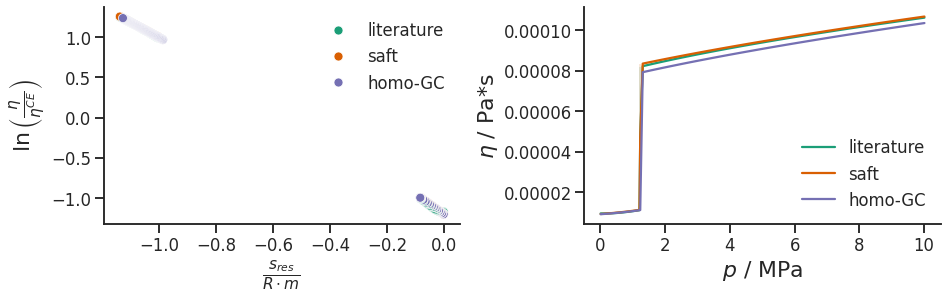

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4), gridspec_kw={'wspace': 0.35})
sns.scatterplot(data=data, x='s*_res/m', y='ln_viscosity_reduced', hue='source', ax=ax[0]);
ax[0].set_xlabel(r"$\frac{s_{res}}{R \cdot m}$", fontsize=22)
ax[0].set_ylabel(r"$\ln\left(\frac{\eta}{\eta^{CE}}\right)$", fontsize=22);
ax[0].legend(frameon=False)

sns.lineplot(data=data, x='pressure', y='viscosity', hue='source', ax=ax[1]);
ax[1].set_xlabel(r"$p$ / MPa", fontsize=22)
ax[1].set_ylabel(r"$\eta$ / Pa*s", fontsize=22);
ax[1].legend(frameon=False)
sns.despine()

In [9]:
# check mean absolute relative deviation in percent
mard = data.groupby('source')['rel.dev.'].apply(lambda x: np.mean(np.abs(x)))
print('Viscosity hexane compared to NIST data at T = 450 K')
print(f'MARD (individual): {mard.saft:.2f} %')
print(f'MARD (homo-GC)   : {mard["homo-GC"]:.2f} %')

Viscosity hexane compared to NIST data at T = 450 K
MARD (individual): 0.81 %
MARD (homo-GC)   : 3.70 %
